# Detect distracted drivers
*Cyril Pecoraro - June 1st 2018*

The goal is to predict what the driver is doing based on pictures

This project is from a [Kaggle competition : State Farm Distracted Driver Detection
](https://www.kaggle.com/c/state-farm-distracted-driver-detection)

There are 10 classes to predict:
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

### Explanation of my work

I used a pre-trained VGG-16 Convolutional Neural Network as a base layer. I then removed the last layer (=top layer) and added a Dense layer with a softmax to output the classification. The optimization algorithm is Adam with a small learning rate: **/tofill/**  . 


The used the weights trained VGG-16 on the image-net dataset for the initializatzion. All the layers beside the last **/tofill/**  were frozen. I then performed data augmentation because the training set is not big. I fine tuned the model using the training set and a validation set (33% split)

I used the Keras library as much as possible in this project as it allows to prototype quickly and surely. I used the dataflow and datagen functions to load the file and preprocess them while feeding them by batches directly to the model.


**/tofill/** epochs were used. The learning_rate, number of epochs and numbers of layers to freeze values were determined by several experiments, not shown here. 


The framework was run on a Google Cloud Virtual Machine with a Tesla K80 GPU.

#### To predict:
* Run the last cell of this notebook
* Or use the script `predict.py [Model/model_name]` with the desired model to obtain prediction and generate a .csv file for Kaggle.

### Content:

1. Model building
2. Preprocessing and data augmentation
3. Train
4. Predict

#### Config to adjust:

In [1]:
# Params 
batch_size = 144 # Try 48; 72; 109; 144; 218; 327 depending on the computing power
n_epoch = 20
learning_rate = 0.0001
n_layers_train = 3 # last n_layers_train layers will be trained

In [2]:
import pandas as pd
import cv2
import os 
import glob
import gc
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpli
% matplotlib inline
import warnings
warnings.filterwarnings("ignore", module="matplotlib")
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from keras.applications import vgg16
from keras.preprocessing import image
from keras import optimizers, callbacks
from keras.models import Sequential, load_model, Model
from keras.layers import Flatten, Dense 
from keras.utils import to_categorical
from tensorflow.python.client import device_lib
import tensorflow as tf

from livelossplot import PlotLossesKeras


Using TensorFlow backend.



First we can observe the distribution of samples per class. This is important as it is a classification problem. In order to avoid the [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox), we don't want to have classes too imbalanced. Here the classes are pretty well balanced. All good !


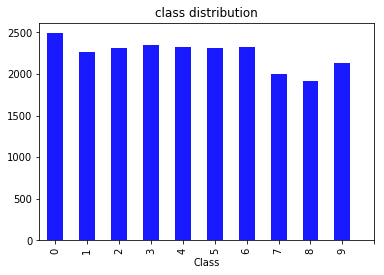

In [3]:
img_list = pd.read_csv('Data/driver_imgs_list.csv')

img_list['class_type'] = img_list['classname'].str.extract('(\d)',expand=False).astype(np.int)
plt.figure()
img_list.groupby(['class_type'])['subject'].count().plot(kind='bar',alpha=0.9, layout=(1,1), color='b')
plt.title('class distribution')
plt.xticks(range(0,11))
plt.xlabel('Class')
plt.show()


## 1. Data loading and preprocessing

To load the files quickly, I use a multi-processor approach which allows to multiply by at least 5 the loading speed.

The data is split in a train/validation set. Then I use data augmentation with transformation to increase the size of the training set.

In [4]:
def load_image(img_file, img_reshape_size):
    """Load an image
    Args:
    - img_file: image file
    - img_reshape_size: shape(w,h) to resize the image
    Return:
    - img: openCV image
    """   
    img = cv2.imread(img_file)
    img = cv2.resize(img, img_reshape_size)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = preprocessing_function=vgg16.preprocess_input(img)
  
    return img

def load_train_dataset(dataset_dir, img_reshape_size, nprocs=10):
    """Load the images located in the main folder dataset_dir Each class is in a separate subfolder
    Args:
    - dataset_dir: path to the directory containing subdirectories of images
    - img_reshape_size: shape(w,h) to resize the image
    - nprocs:Number of processors to use
    Return:
    - X: numpy array with each image data as a row
    - y: numpy array with each class as an integer for each image
    """
    X = []
    y = []
    # Train dataset
    for i in range(10):
        path = os.path.join(dataset_dir, 'c'+str(i),'*.jpg')
        files = glob.glob(path)

        X.extend(Parallel(n_jobs=nprocs)(delayed(load_image)(im_file, img_reshape_size) for im_file in files))
        y.extend([i]*len(files))
        print('folder train/c'+str(i), 'loaded')

    X = np.asarray(X, dtype=np.float16)
    y = np.asarray(y)
    return X, y

In [5]:
# Image sizes - Requirements of the CNN model
img_reshape_size = (224,224)

# Working directories
dataset_dir = 'Data'
dataset_dir_train = os.path.join(dataset_dir, 'train')

# Load train dataset
print('Load dataset train')
X_train_, y_train_ = load_train_dataset(dataset_dir_train, img_reshape_size)
X_train_[:, :, :, 0] -= 103.939
X_train_[:, :, :, 1] -= 116.779
X_train_[:, :, :, 2] -= 123.68   
        
        # Creation of a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, 
                                                  test_size=0.3, 
                                                  random_state=35)

# One hot encoding of the classes
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# Shapes 
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)#
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

# Image Data Generator for preprocessing and data augmentation
train_datagen = image.ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        rotation_range=8,
        fill_mode='nearest'
                                        )

train_generator = train_datagen.flow(x=X_train, y=y_train,
                            batch_size=batch_size,
                            shuffle=False,
                            seed=42)

Load dataset train
folder train/c0 loaded
folder train/c1 loaded
folder train/c2 loaded
folder train/c3 loaded
folder train/c4 loaded
folder train/c5 loaded
folder train/c6 loaded
folder train/c7 loaded
folder train/c8 loaded
folder train/c9 loaded
X_train shape: (15696, 224, 224, 3)
y_train shape: (15696, 10)
X_val shape: (6728, 224, 224, 3)
y_val shape: (6728, 10)


## 2. Model building

I use the VGG16 implementation and I remove the last layer to add a layer that suits my needs. In this case it is a 10 Fully connected layer so that I can use the CNN as a 10-class classifier.

In [6]:
def create_VGG16_model(n_classes=10, n_layers_train=2, learning_rate=0.0001):
    """Load the images located in the main folder dataset_dir Each class is in a separate subfolder
    Args:
    - n_classes: number of classes to predict for the classifier
    - n_layers_train: number of last layers to train. The other layers will be frozen.
    Return:
    - model: Keras model
    """
    #Load the VGG model
    vgg16_base = vgg16.VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))    

    # Remove top layer and connect custom dense layer
    fc2 = vgg16_base.get_layer('fc2').output
    mypredictions = Dense(n_classes, activation='softmax', name='mypredictions')(fc2)
    model = Model(inputs=vgg16_base.input, outputs=mypredictions)
    
    model.summary()
    # Freeze the layers except the last n_layers_train layers
    for layer in model.layers[:-n_layers_train]:
        layer.trainable = False
    for layer in model.layers[:]:
        print(layer, layer.trainable)    


    model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.Adam(lr=learning_rate),
          metrics=['accuracy'])

    model.summary()
    return model

In [7]:
# Create and compile model
model = create_VGG16_model(n_layers_train=n_layers_train, learning_rate=learning_rate)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## 3. Train

In [8]:
tbCallBack = callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=False, write_images=False)

# fits the model on batches with real-time data augmentation:
model_history = model.fit_generator(train_generator,
                                    validation_data=(X_val, y_val),
                                    shuffle=True,
                                    epochs=n_epoch,
                                    steps_per_epoch=np.ceil(X_train.shape[0]//batch_size),
                                    callbacks=[tbCallBack],
                                    verbose=1,
                                    use_multiprocessing=True)

Epoch 1/20
109/109 [==============================] - 277s 3s/step - loss: 0.5615 - acc: 0.8248 - val_loss: 0.0736 - val_acc: 0.9793
Epoch 2/20
109/109 [==============================] - 256s 2s/step - loss: 0.0798 - acc: 0.9733 - val_loss: 0.0805 - val_acc: 0.9729
Epoch 3/20
109/109 [==============================] - 257s 2s/step - loss: 0.0615 - acc: 0.9801 - val_loss: 0.0348 - val_acc: 0.9902
Epoch 4/20
109/109 [==============================] - 256s 2s/step - loss: 0.0439 - acc: 0.9854 - val_loss: 0.0487 - val_acc: 0.9848
Epoch 5/20
109/109 [==============================] - 256s 2s/step - loss: 0.0455 - acc: 0.9850 - val_loss: 0.0448 - val_acc: 0.9857
Epoch 6/20
109/109 [==============================] - 256s 2s/step - loss: 0.0357 - acc: 0.9885 - val_loss: 0.0307 - val_acc: 0.9911
Epoch 7/20
109/109 [==============================] - 256s 2s/step - loss: 0.0373 - acc: 0.9890 - val_loss: 0.0236 - val_acc: 0.9930
Epoch 8/20
109/109 [==============================] - 255s 2s/step - 

Now that the model is trained, we can save it for further predictions.

Use the script `predict.py [Model/model_name]` to obtain predictions and generate a .csv file for Kaggle

In [9]:
# Save model and Exit
if not os.path.isdir('Model'):
    os.mkdir('Model')
filename = 'VGG16_lr'+str(learning_rate)+'_train'+str(n_layers_train)+'_epochs'+str(n_epoch)+'.h5'

model_file = os.path.join('Model', filename)
model.save(model_file)
print('File', filename, 'saved')


File VGG16_lr0.0001_train3_epochs20.h5 saved


## 4. Predict and submit

Using the model that was trained in this notebook, the script is going to predict the results for the test set and directly submit the results to Kaggle

In [10]:
import gc
#delete when no longer needed
del X_train, X_val, X_train_, model_history
#collect residual garbage
gc.collect()

5550

In [1]:
model_file='Model/VGG16_lr0.0001_train3_epochs20.h5'

In [2]:
%run -i 'predict.py' $model_file


Using TensorFlow backend.


Working with model Model/VGG16_lr0.0001_train3_epochs20.h5
Load dataset test
Dataset test loaded
X_test shape: (79726, 224, 224, 3)
79726/79726 [==============================] - 771s 10ms/step
File VGG16_lr0.0001_train3_epochs20_2018-07-06-21-02 saved


In [1]:
!kaggle competitions submit -c state-farm-distracted-driver-detection -f "$(ls -t Output/submission-* | head -1)" -m "."


Successfully submitted to State Farm Distracted Driver Detection